#### Tech Challenge - Fase 2 - Machine Learning and Time Series

#### O problema 

Desenvolver um modelo preditivo capaz de prever se o índice IBOVESPA vai fechar em alta ou baixa no dia seguinte, com base em dados históricos do próprio índice

#### O que é o índice Ibovespa 

É o principal indicador de desempenho das ações negociadas na B3 e reúne as empresas mais importantes do mercado de capitais brasileiro. Foi criado em 1968 e, ao longo desses 50 anos, consolidou-se como referência para investidores ao redor do mundo.


https://pt.wikipedia.org/wiki/Ibovespa

https://www.b3.com.br/pt_br/market-data-e-indices/indices/indices-amplos/ibovespa.htm

#### Fonte de dados 

Dados históricos do índice IBOVESPA disponíveis publicamente no link https://br.investing.com/indices/bovespa-historical-data e importando para o seguinte repositorio do Github https://github.com/RicardViana/fiap-Machine-Learning-and-Time-Series/blob/main/Dados%20Hist%C3%B3ricos%20Ibovespa.csv

#### Dicionário de dados


| Nome da Coluna | Descrição | Tipo de Dado |
| :--- | :--- | :--- |
| `Data` | A data da observação, no formato "DD/MM/AAAA". | Texto (object) |
| `Ultimo` | O preço de fechamento do Ibovespa no dia. | Numérico (float64) |
| `Abertura` | O preço de abertura do Ibovespa no dia. | Numérico (float64) |
| `Maxima` | O preço máximo atingido pelo Ibovespa no dia. | Numérico (float64) |
| `Minima` | O preço mínimo atingido pelo Ibovespa no dia. | Numérico (float64) |
| `Volume` | O volume de negociações do dia. Os valores são representados em texto com sufixos (ex: "B" para bilhões, "M" para milhões). | Texto (object) |
| `Variacao` | A variação percentual do Ibovespa no dia. | Texto (object) |

#### Objetivo

Criar um modelo que preveja se o fechamento do IBOVESPA do dia seguinte será maior ou menor que o do dia atual, ou seja:

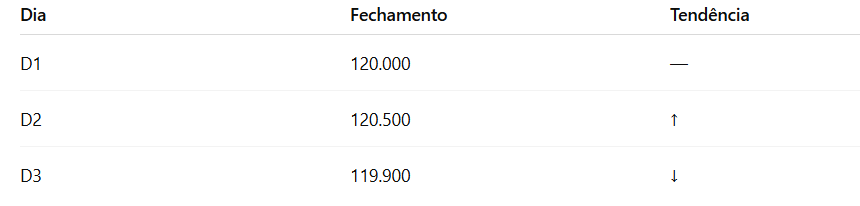

Onde deve prever a tendência (↑ ou ↓) com acuracidade mínima de 75% em um conjunto de teste, esse que contera o último mês (30 dias) de dados disponíveis

#### Desenvolvimento

##### Importação de bibliotecas e pacotes

In [819]:
# Importar biblioteca completa
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import calendar
import pandas_ta as ta
import requests

# Importar função especifica de um módulo
from statsmodels.tsa.seasonal import seasonal_decompose # --> Gerar a decomposição dos dados
from sklearn.preprocessing import StandardScaler # --> Normalizar os dados
from datetime import date

# Importar função especifica de um módulo --> Modelos de ML
from sklearn.ensemble import RandomForestClassifier # --> Modelo de ML Random Forest
from sklearn.linear_model import LogisticRegression # --> Modelo de ML Regressão Logistica 
from catboost import CatBoostClassifier # --> Modelo de ML CatBoost
from lightgbm import LGBMClassifier # --> Modelo de ML LightGBM
from xgboost import XGBClassifier # --> Modelo de ML XGBoost
from sklearn.svm import SVC # --> Modelo de ML SVC

# Importar função especifica de um módulo --> Metricas para analisar o modelo  
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score

# Importar função especifica de um módulo --> Melhores hiperparametros 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline

# Outros import
import ipywidgets as widgets
from IPython.display import display

##### Criação de funções (DEF)

In [820]:
# Função para gerar a matriz de confusão, a curva roc e a análise textual
def analisar_modelo_selecionado(nome_modelo, modelos_avaliados, y_test, x_test, x_test_scaled):

    # Coletar os dados
    modelo_selecionado = modelos_avaliados[nome_modelo]["modelo"]
    previsoes_selecionadas = modelos_avaliados[nome_modelo]["previsoes"]

    print(f"Análise Detalhada para o Modelo: {nome_modelo}")

    # Gerar os graficos
    cm = confusion_matrix(y_test, previsoes_selecionadas)
    plt.figure(figsize=(14, 6))
    
    # Gráfico 1: Matriz de Confusão
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Previsto Negativo', 'Previsto Positivo'],
                yticklabels=['Real Negativo', 'Real Positivo'])
    plt.title(f'Matriz de Confusão - {nome_modelo}', fontsize=14)
    plt.ylabel('Valor Real')
    plt.xlabel('Valor Previsto')

    # Gráfico 2: Curva ROC e AUC
    auc = None
    if hasattr(modelo_selecionado, "predict_proba"):
        x_test_scaled_df = pd.DataFrame(x_test_scaled, columns=x_test.columns)
        y_pred_proba = modelo_selecionado.predict_proba(x_test_scaled_df)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

        plt.subplot(1, 2, 2)
        plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {auc:.4f})')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Classificador Aleatório')
        plt.xlabel('Taxa de Falsos Positivos (FPR)')
        plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
        plt.title(f'Curva ROC - {nome_modelo}', fontsize=14)
        plt.legend()
        plt.grid()
    else:
        plt.subplot(1, 2, 2)
        plt.text(0.5, 0.5, 'Curva ROC não disponível.', ha='center', va='center', fontsize=12)
        plt.title(f'Curva ROC - {nome_modelo}', fontsize=14)
        plt.gca().set_axis_off()

    plt.tight_layout()
    plt.show()

    # Análise e Interpretação Textual
    # Extrai os valores da matriz de confusão:
    # cm[0, 0] = Verdadeiros Negativos (VN)
    # cm[0, 1] = Falsos Positivos (FP)
    # cm[1, 0] = Falsos Negativos (FN)
    # cm[1, 1] = Verdadeiros Positivos (VP)

    vn, fp, fn, vp = cm.ravel()
    
    total_reais_positivos = vp + fn
    total_reais_negativos = vn + fp
    
    print("\nInterpretação dos Resultados\n")
    
    # 1. Análise da Matriz de Confusão
    print("1. Análise da Matriz de Confusão:")
    print(f"   - O modelo classificou corretamente {vp} casos como 'Positivo' (Verdadeiros Positivos).")
    print(f"   - O modelo classificou corretamente {vn} casos como 'Negativo' (Verdadeiros Negativos).")
    print(f"   - Ocorreram {fp} erros do Tipo I, onde o modelo previu 'Positivo' quando o real era 'Negativo' (Falsos Positivos).")
    print(f"   - Ocorreram {fn} erros do Tipo II, onde o modelo previu 'Negativo' quando o real era 'Positivo' (Falsos Negativos).")
    
    # 2. Análise da Curva ROC e AUC
    if auc is not None:
        print("\n2. Análise da Curva ROC e AUC:")
        print(f"   - O valor da AUC (Area Under the Curve) foi de {auc:.4f}.")
        
        # Interpretação do valor da AUC
        if auc >= 0.9:
            interpretacao_auc = "uma excelente capacidade de discriminação entre as classes."
        elif auc >= 0.8:
            interpretacao_auc = "uma boa capacidade de discriminação."
        elif auc >= 0.7:
            interpretacao_auc = "uma capacidade de discriminação aceitável."
        elif auc >= 0.6:
            interpretacao_auc = "uma capacidade de discriminação fraca."
        else:
            interpretacao_auc = "uma capacidade de discriminação muito fraca, pouco melhor que um palpite aleatório."
            
        print(f"   - Isso indica que o modelo possui {interpretacao_auc}")
        print("   - Quanto mais a linha azul se afasta da linha vermelha tracejada (classificador aleatório) e se aproxima do canto superior esquerdo, melhor é o desempenho do modelo.")

In [861]:
# Função para analisar, plotar e interpretar a importância das features
def analisar_importancia_features(nome_modelo, modelos_avaliados, x_train):
    """
    Esta função extrai, plota e interpreta a importância das features 
    para um modelo de machine learning.
    """
    
    # Coleta de Dados
    modelo_selecionado = modelos_avaliados[nome_modelo]["modelo"]
    print(f"Análise de Importância das Features para o Modelo: {nome_modelo}")
    
    importances = None
    metodo_importancia = ""
    
    # Verifica se o modelo tem o atributo 'feature_importances_'
    if hasattr(modelo_selecionado, 'feature_importances_'):
        importances = modelo_selecionado.feature_importances_
        metodo_importancia = "ganho por impureza/divisão (típico de modelos de árvore)"
        
    # Verifica se o modelo tem o atributo 'coef_'
    elif hasattr(modelo_selecionado, 'coef_'):
        importances = np.abs(modelo_selecionado.coef_[0])
        metodo_importancia = "magnitude do coeficiente (típico de modelos lineares)"
        
    # Se o modelo não tiver um atributo de importância direta
    else:
        plt.figure(figsize=(10, 5))
        plt.text(0.5, 0.5, f'A importância das features não está diretamente disponível\npara o modelo {nome_modelo}.', 
                 ha='center', va='center', fontsize=12, color='red')
        plt.title(f'Importância das Features - {nome_modelo}', fontsize=16)
        plt.gca().set_axis_off()
        plt.show()
        return

    #Criação do Gráfico
    feature_importance_df = pd.DataFrame({
        'Feature': x_train.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 5)) 
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis', hue='Feature', legend=False)
    plt.title(f'Importância das Features - {nome_modelo}', fontsize=16)
    plt.xlabel('Pontuação de Importância', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Análise e Interpretação Textual 
    print("\nInterpretação da Importância das Features\n")
    
    # Pegar as 5 features mais importantes (ou menos, se não houver 5)
    top_n = min(5, len(feature_importance_df))
    top_features = feature_importance_df.head(top_n)
    
    print(f"Esta análise mostra quais características (features) o modelo '{nome_modelo}' considerou mais relevantes para fazer suas previsões.")
    if metodo_importancia:
        print(f"A importância foi calculada usando a métrica de {metodo_importancia}.\n")
        
    print(f"As {top_n} features mais influentes são:")
    
    # Calcula a importância relativa para dar mais contexto
    total_importance = top_features['Importance'].sum()
    
    for index, row in top_features.iterrows():
        feature_name = row['Feature']
        importance_score = row['Importance']
        relative_importance = (importance_score / total_importance) * 100 
        print(f"  {index+1}. {feature_name} (Importância: {importance_score:.3f}, Contribuição Relativa: {relative_importance:.1f}%)")

    print("\nConclusão:")
    print(f"   - A feature '{top_features['Feature'].iloc[0]}' é, de longe, o fator mais decisivo para o modelo.")
    print("   - Variáveis como as listadas acima são os principais impulsionadores do resultado previsto.")
    print("   - Isso pode sugerir que esforços para melhorar a qualidade dos dados ou para engenharia de features devem se concentrar principalmente nesses fatores.")

##### Análise Exploratória de Dados (EDA)

In [822]:
"""

Com sugestão do colega da pós Tiago Turra existe uma biblioteca chamada yfinance (https://pypi.org/project/yfinance/) que possi os mesmo dados do site https://br.investing.com/indices/bovespa-historical-data

"""

# Importando os dados via yfinance apenas para referencia
# progress --> Não gerar um print do progresso
# auto_adjust --> corrigir o histórico de preços
# multi_level_index --> Utilizando para evitar gerar coluna com o nome do ticket, exemplo ('Close', '^BVSP')

dados_yf = yf.download('^BVSP', period="max", interval="1d", auto_adjust=True,  progress=False, multi_level_index=False)

print("Primeiros dados")
display(dados_yf.head())

print("\nUltimos dados")
display(dados_yf.tail())

Primeiros dados


,Close,High,Low,Open,Volume
Date,,,,,
1993-04-27,24.500000,25.400000,24.500000,24.799999,0
1993-04-28,24.299999,24.600000,23.700001,24.500000,0
1993-04-29,23.700001,24.799999,23.700001,24.299999,0
1993-04-30,24.100000,24.200001,23.700001,23.700001,0
1993-05-03,24.100000,24.400000,23.799999,24.100000,0



Ultimos dados


,Close,High,Low,Open,Volume
Date,,,,,
2025-07-25,133524.000000,134204.0,133285.0,133820.0,5560900
2025-07-28,132129.000000,133902.0,131550.0,133538.0,6625600
2025-07-29,132726.000000,133346.0,132130.0,132130.0,6324800
2025-07-30,133990.000000,134368.0,131883.0,132702.0,8655300
2025-07-31,133071.046875,0.0,0.0,0.0,0


In [823]:
# Opção de já transformar o campa data em Data e Index

link = r"https://raw.githubusercontent.com/RicardViana/fiap-Machine-Learning-and-Time-Series/refs/heads/main/Dados%20Hist%C3%B3ricos%20Ibovespa.csv"
dados_origem_teste = pd.read_csv(link, sep= ";", thousands='.', decimal=',', parse_dates=["Data"], dayfirst=True, index_col="Data")
display(dados_origem_teste.head())

,Ultimo,Abertura,Maxima,Minima,Volume,Variacao
Data,,,,,,
1995-01-02,4301,4354,4398,4300,"4,10B","-1,22%"
1995-01-03,4098,4370,4386,4094,"8,35B","-4,72%"
1995-01-04,3968,4098,4098,3861,"11,95B","-3,17%"
1995-01-05,4037,3968,4040,3944,"8,76B","1,74%"
1995-01-06,3827,4037,4106,3813,"12,02B","-5,20%"


In [824]:
# Importar os dados via github 
# Necessario o uso do arumento thousands e decimal para não ter problema com o data frame --> o . na fonte é para separar o milhar

usar_yf = "Sim"

if usar_yf == "Sim":
    dados_origem = dados_yf[["Close", "High", "Low", "Open"]].copy()
    dados_origem = dados_origem.rename(columns={"Close":"Ultimo", "Open":"Abertura", "High":"Maxima", "Low":"Minima"})

else:
    link = r"https://raw.githubusercontent.com/RicardViana/fiap-Machine-Learning-and-Time-Series/refs/heads/main/Dados%20Hist%C3%B3ricos%20Ibovespa.csv"
    dados_origem = pd.read_csv(link, sep= ";", thousands='.', decimal=',', index_col="Data")

In [825]:
# Verificando os dados via .head e .tail

print("Primeiros dados (.head)")
display(dados_origem.head())

print("\nUltimos dados (.tail)")
display(dados_origem.tail())

Primeiros dados (.head)


,Ultimo,Maxima,Minima,Abertura
Date,,,,
1993-04-27,24.500000,25.400000,24.500000,24.799999
1993-04-28,24.299999,24.600000,23.700001,24.500000
1993-04-29,23.700001,24.799999,23.700001,24.299999
1993-04-30,24.100000,24.200001,23.700001,23.700001
1993-05-03,24.100000,24.400000,23.799999,24.100000



Ultimos dados (.tail)


,Ultimo,Maxima,Minima,Abertura
Date,,,,
2025-07-25,133524.000000,134204.0,133285.0,133820.0
2025-07-28,132129.000000,133902.0,131550.0,133538.0
2025-07-29,132726.000000,133346.0,132130.0,132130.0
2025-07-30,133990.000000,134368.0,131883.0,132702.0
2025-07-31,133071.046875,0.0,0.0,0.0


In [826]:
# Ajustar o formato da coluna Data 

if usar_yf == "Não":
    dados_origem.index = pd.to_datetime(dados_origem.index, format = "%d/%m/%Y")

In [827]:
# Verificand os dados os dados do data frame dados_origem com o dados_yf --> Verificar se há diferença 

if usar_yf == "Não":
    print("Dados do data frame dados_origem")
    display(dados_origem[['Ultimo', 'Abertura', 'Maxima', 'Minima']].tail())

    print("\nDados do data frame dados_yf")
    display(dados_yf[['Close', 'Open', 'High', 'Low']].query("Date >= '2025-06-30 00:00:00' and Date <= '2025-07-04 00:00:00'"))


In [828]:
# Veficiando os dados dados do data frame 

dados_origem.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7989 entries, 1993-04-27 to 2025-07-31
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Ultimo    7989 non-null   float64
 1   Maxima    7989 non-null   float64
 2   Minima    7989 non-null   float64
 3   Abertura  7989 non-null   float64
dtypes: float64(4)
memory usage: 312.1 KB


In [829]:
# Verificando os dados nulos
dados_origem.isnull().sum()

Ultimo      0
Maxima      0
Minima      0
Abertura    0
dtype: int64

In [830]:
# Verificando os registros que estão nulos 
dados_origem[dados_origem.isnull().any(axis=1)]

,Ultimo,Maxima,Minima,Abertura
Date,,,,


In [831]:
# Gerando a estatistica descritiva do data frame 

dados_origem.describe()

,Ultimo,Maxima,Minima,Abertura
count,7989.000000,7989.000000,7989.000000,7989.000000
mean,50895.675985,51361.944199,50373.208561,50867.500601
std,39096.505384,39371.447914,38798.623229,39079.191523
min,23.700001,0.000000,0.000000,0.000000
25%,13246.000000,13376.000000,13076.000000,13239.000000
50%,50299.000000,50909.000000,49788.000000,50284.000000
75%,70792.000000,71263.000000,70145.000000,70757.000000
max,141478.000000,141537.000000,140597.000000,141265.000000


In [832]:
# Verificando o intervalo de data dos dados 

print(f"Data inicial é {dados_origem.index.min()}")
print(f"Data final   é {dados_origem.index.max()}")

Data inicial é 1993-04-27 00:00:00
Data final   é 2025-07-31 00:00:00


In [833]:
# Criando um novo data frame apenas com os campos necessarios

dados_ultimo = dados_origem["Ultimo"].copy()
dados_ultimo.tail()

Date
2025-07-25    133524.000000
2025-07-28    132129.000000
2025-07-29    132726.000000
2025-07-30    133990.000000
2025-07-31    133071.046875
Name: Ultimo, dtype: float64

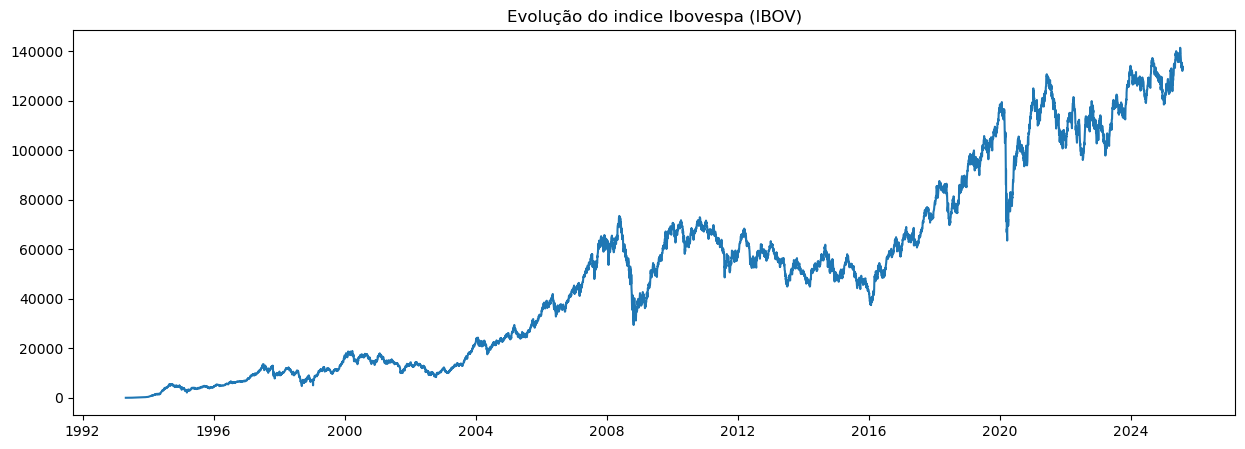

In [834]:
# Plotando um grafico de linha 

plt.figure(figsize=(15,5))
plt.plot(dados_ultimo.index,dados_ultimo)
plt.title("Evolução do indice Ibovespa (IBOV)")
plt.show()

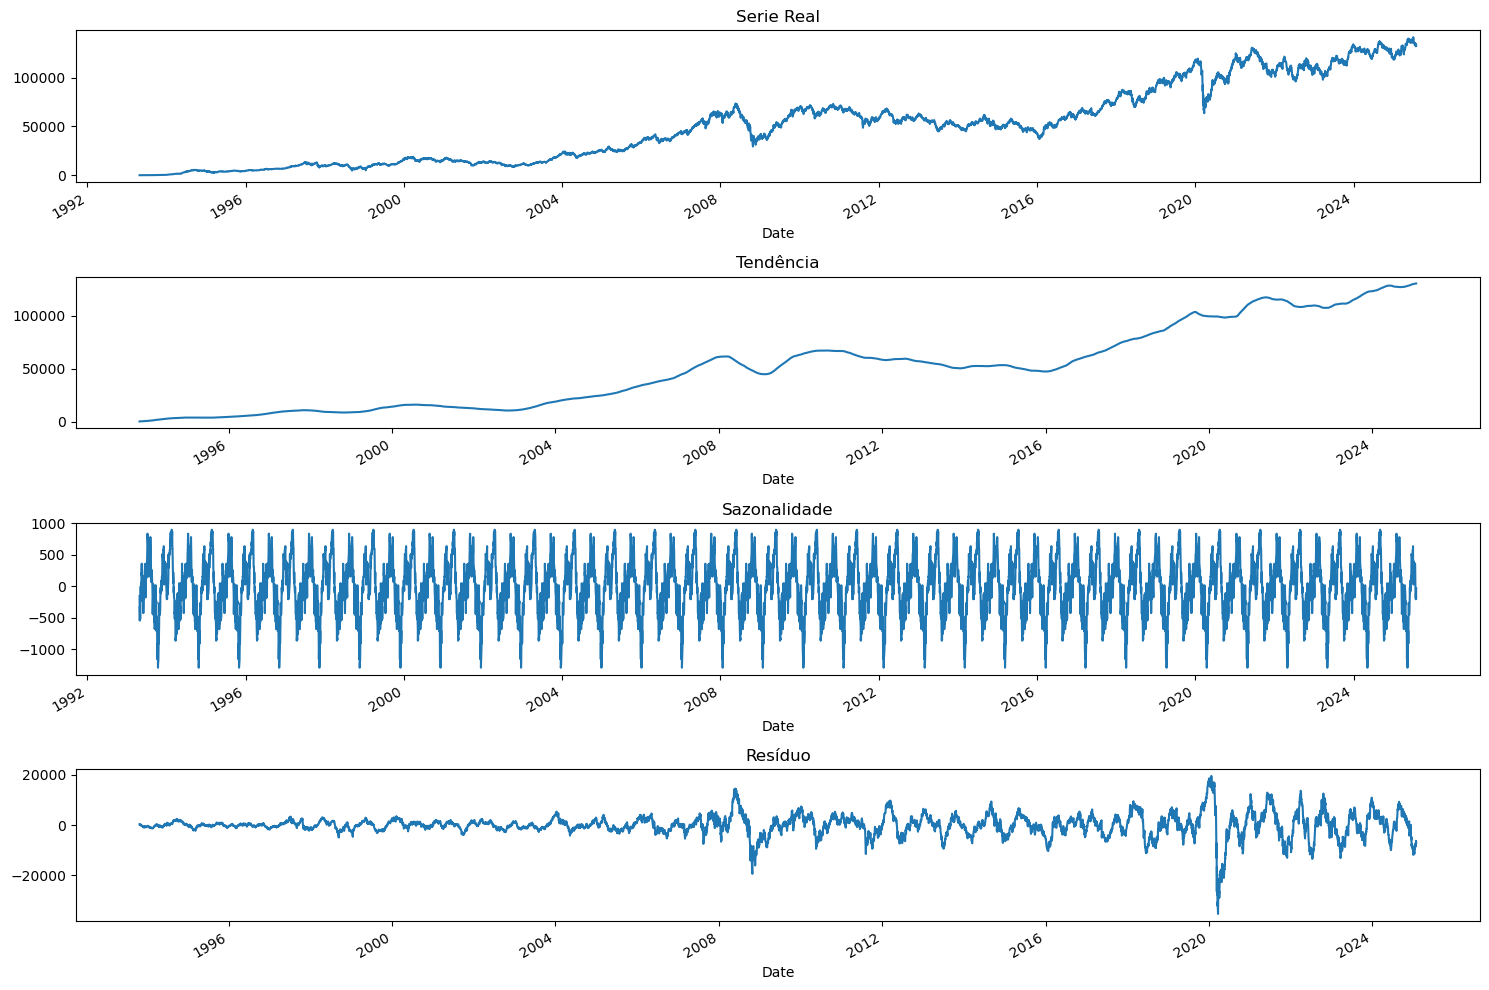

In [835]:
# Realizar a decomposição da seria temporal -->  tendência (trend), sazonalidade (seasonal) e resíduo (resid) e gerar o graficos 

periodo = 252 # Média de dias uteis

resultados = seasonal_decompose(dados_ultimo, period=periodo)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

resultados.observed.plot(ax=ax1)
ax1.set_title("Serie Real")

resultados.trend.plot(ax=ax2)
ax2.set_title("Tendência")

resultados.seasonal.plot(ax=ax3)
ax3.set_title("Sazonalidade")

resultados.resid.plot(ax=ax4)
ax4.set_title("Resíduo")

plt.tight_layout()
plt.show()

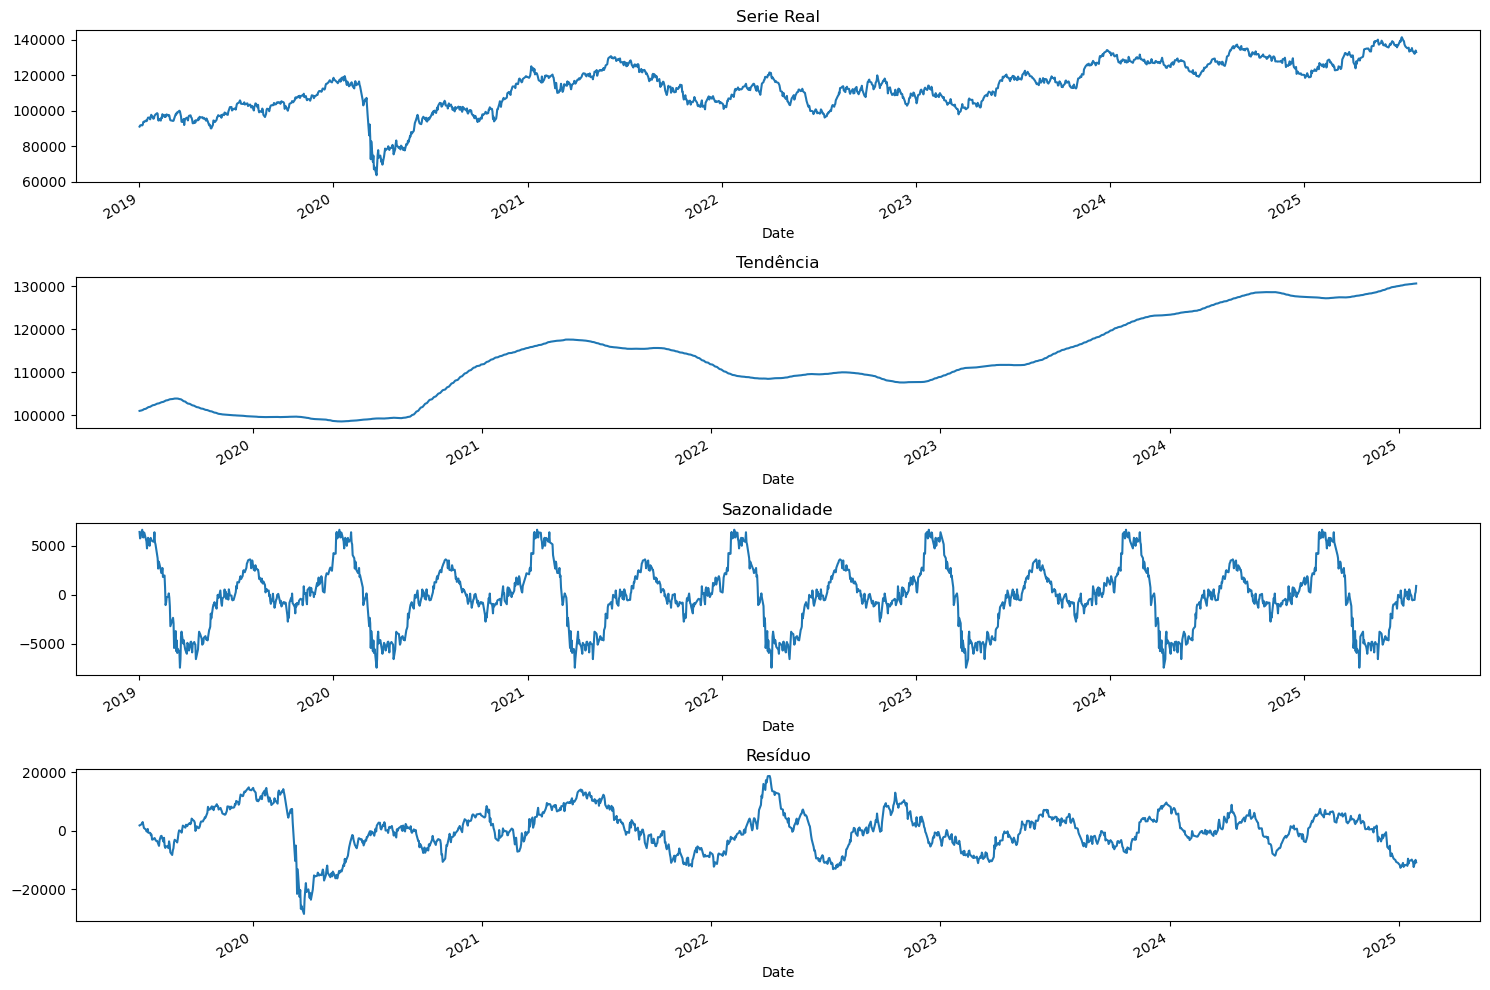

In [836]:
"""

O ano de 2020 houve a pandemia e dessa forma, plotamos novamente o decompose para verificar a partir do ano de 2019 

"""

periodo = 252  # Média de dias úteis

# Filtrar os dados a partir de 2019
dados_ultimo_2019 = dados_ultimo[dados_ultimo.index >= "2019-01-01"]

# Realizar a decomposição
resultados = seasonal_decompose(dados_ultimo_2019, period=periodo)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))

resultados.observed.plot(ax=ax1)
ax1.set_title("Serie Real")

resultados.trend.plot(ax=ax2)
ax2.set_title("Tendência")

resultados.seasonal.plot(ax=ax3)
ax3.set_title("Sazonalidade")

resultados.resid.plot(ax=ax4)
ax4.set_title("Resíduo")

plt.tight_layout()
plt.show()

##### Feature Engineering

In [837]:
# Criar um novo data frame com os dados originais

excluir_anos = "Não"
anos_excluir = [2020]

if excluir_anos == "Sim":
    mascara = ~dados_origem.index.year.isin(anos_excluir)
    dados = dados_origem.loc[mascara, ["Ultimo", "Abertura", "Maxima", "Minima"]].copy()

else:
    dados = dados_origem[["Ultimo", "Abertura", "Maxima", "Minima"]].copy()

In [838]:
# Alterando o nome das colunas 

dados.index.name = "data"
dados = dados.rename(columns={"Ultimo":"ultimo", "Abertura":"abertura", "Maxima":"maxima", "Minima":"minima"})

In [839]:
# Ordernando os dados 

dados = dados.sort_index()

In [840]:
# Criar a variavel Target (Alvo) --> 1 para sobe e 0 para desce 
# Avaliamos o valor atual com o valor do proximo dia e dessa forma conseguimos definir se o dia seguinte subiu (1) ou desceu (0)

# Versão sem o limite 
#dados['ultimo_amanha'] = dados["ultimo"].shift(-1) # --> Etapa apenas para enteder os calculos e não é necessarios para o modelo
#dados['ultimo_diferenca'] = dados["ultimo"].shift(-1) - dados["ultimo"] # --> Etapa apenas para enteder os calculos e não é necessarios para o modelo

dados['target'] = (dados["ultimo"].shift(-1) > dados["ultimo"]).astype(int)

# Versão com o limite 
# limitar o percentual
#limite = 0.005  # 0.5%

# Calcula a variação percentual do fechamento do dia seguinte em relação ao dia atual
#delta = (dados["ultimo"].shift(-1) - dados["ultimo"]) / dados["ultimo"]

# Cria a coluna target: 1 para alta acima do limite, 0 para baixa abaixo do limite, np.nan para ruído
#dados["target"] = np.where(delta > limite, 1, np.where(delta < -limite, 0, np.nan))

dados.tail()

,ultimo,abertura,maxima,minima,target
data,,,,,
2025-07-25,133524.000000,133820.0,134204.0,133285.0,0
2025-07-28,132129.000000,133538.0,133902.0,131550.0,1
2025-07-29,132726.000000,132130.0,133346.0,132130.0,1
2025-07-30,133990.000000,132702.0,134368.0,131883.0,0
2025-07-31,133071.046875,0.0,0.0,0.0,0


In [841]:
# Criar as variações percentuais (lags) --> Comparar percentualmente o dia de hoje com n dias anteriores
# Features Defasadas (Lagged Features) --> Os preços e volumes dos dias anteriores são informações muito importantes

qtd_lags = 10

for i in range (1, qtd_lags+1):
    dados[f"lag_{i}"] = dados["ultimo"].pct_change(i)

dados.tail()

,ultimo,abertura,maxima,minima,target,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
data,,,,,,,,,,,,,,,
2025-07-25,133524.000000,133820.0,134204.0,133285.0,0,-0.002122,-0.013622,-0.003820,-0.004793,0.001065,-0.015056,-0.014663,-0.012762,-0.013119,-0.019554
2025-07-28,132129.000000,133538.0,133902.0,131550.0,1,-0.010448,-0.012548,-0.023927,-0.014228,-0.015190,-0.009394,-0.025346,-0.024957,-0.023076,-0.023430
2025-07-29,132726.000000,132130.0,133346.0,132130.0,1,0.004518,-0.005976,-0.008086,-0.019517,-0.009773,-0.010740,-0.004918,-0.020942,-0.020552,-0.018662
2025-07-30,133990.000000,132702.0,134368.0,131883.0,0,0.009523,0.014085,0.003490,0.001360,-0.010180,-0.000343,-0.001319,0.004558,-0.011618,-0.011224
2025-07-31,133071.046875,0.0,0.0,0.0,0,-0.006858,0.002600,0.007130,-0.003392,-0.005508,-0.016968,-0.007199,-0.008169,-0.002331,-0.018397


In [842]:
# Criar médias moveis

dias_medias = [5, 22, 66, 132, 252] 
criar_media = "Não"

if criar_media == "Sim":
    
    for dias in dias_medias:
        dados[f"MA_{dias}"] = dados["ultimo"].rolling(window=dias).mean().shift(1)

    dados.tail()

In [843]:
# Criar Volatilidade

criar_volatilidade = "Sim"

if criar_volatilidade == "Sim":
    dados["Volatilidade"] = dados["maxima"] - dados["minima"]
    dados["Volatilidade_relativa"] = dados["Volatilidade"] / dados["minima"]

    dados.tail()

In [844]:
# Criar restante dos indicadores tecnicos
# mme --> Média Móvel Exponencial (EMA - Exponential Moving Average): Semelhante à SMA, mas dá mais peso aos preços mais recentes, reagindo mais rápido a mudanças
# rsi --> Índice de Força Relativa (RSI - Relative Strength Index): Mede a velocidade e a mudança dos movimentos de preços, indicando se um ativo está sobrecomprado ou sobrevendido.
# macd --> Convergência e Divergência de Médias Móveis (MACD - Moving Average Convergence Divergence): Usa duas médias móveis exponenciais para gerar sinais de compra e venda
# bbands --> Bandas de Bollinger (Bollinger Bands): Medem a volatilidade do mercado, consistindo em uma média móvel (banda do meio) e duas bandas de desvio padrão (superior e inferior)
# stoch --> Oscilador Estocástico (%K e %D): Compara o preço de fechamento de um ativo com sua faixa de preço durante um determinado período

custom_strategy = ta.Strategy(
    name="Estrategia Mista",
    description="SMA, EMA, RSI, MACD, BBands, e Stochastic",
    ta=[
        {"kind": "ema", "length": 20},
        {"kind": "rsi", "length": 14},
        {"kind": "macd", "fast": 12, "slow": 26, "signal": 9},
        {"kind": "bbands", "length": 20, "std": 2},
        {"kind": "stoch", "k": 14, "d": 3}
    ]
)

incluir_dados = "Não"

if incluir_dados == "Sim":
    dados = dados.rename(columns={"ultimo":"close", "abertura":"open", "maxima":"high", "minima":"low"})
    dados.ta.strategy(custom_strategy)
    dados = dados.rename(columns={"close":"ultimo", "open":"abertura", "high":"maxima", "low":"minima"})
    dados.tail()


In [845]:
# Tratar o data frame para evitar o data leakage --> empurrar os dados para a linha de baixo

colunas_excluir = ["target"]
features_a_deslocar = [col for col in dados.columns if col not in colunas_excluir]

dados[features_a_deslocar] = dados[features_a_deslocar].shift(1)

dados.tail()

,ultimo,abertura,maxima,minima,target,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,Volatilidade,Volatilidade_relativa
data,,,,,,,,,,,,,,,,,
2025-07-25,133808.0,135357.0,135363.0,133648.0,0,-0.011524,-0.001701,-0.002676,0.003194,-0.012961,-0.012567,-0.010662,-0.011020,-0.017469,-0.021464,1715.0,0.012832
2025-07-28,133524.0,133820.0,134204.0,133285.0,1,-0.002122,-0.013622,-0.003820,-0.004793,0.001065,-0.015056,-0.014663,-0.012762,-0.013119,-0.019554,919.0,0.006895
2025-07-29,132129.0,133538.0,133902.0,131550.0,1,-0.010448,-0.012548,-0.023927,-0.014228,-0.015190,-0.009394,-0.025346,-0.024957,-0.023076,-0.023430,2352.0,0.017879
2025-07-30,132726.0,132130.0,133346.0,132130.0,0,0.004518,-0.005976,-0.008086,-0.019517,-0.009773,-0.010740,-0.004918,-0.020942,-0.020552,-0.018662,1216.0,0.009203
2025-07-31,133990.0,132702.0,134368.0,131883.0,0,0.009523,0.014085,0.003490,0.001360,-0.010180,-0.000343,-0.001319,0.004558,-0.011618,-0.011224,2485.0,0.018842


In [846]:
# Excluir do data frame os registros vazios

dados = dados.dropna()
dados.head()

,ultimo,abertura,maxima,minima,target,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,Volatilidade,Volatilidade_relativa
data,,,,,,,,,,,,,,,,,
1993-05-12,26.299999,25.200001,26.299999,25.100000,1,0.043651,0.019380,0.027344,0.069106,0.056225,0.091286,0.091286,0.109705,0.082305,0.073469,1.199999,0.047809
1993-05-13,26.700001,26.299999,27.100000,26.200001,1,0.015209,0.059524,0.034884,0.042969,0.085366,0.072289,0.107884,0.107884,0.126582,0.098765,0.900000,0.034351
1993-05-14,27.400000,26.700001,27.600000,26.700001,1,0.026217,0.041825,0.087302,0.062016,0.070312,0.113821,0.100402,0.136929,0.136929,0.156118,0.900000,0.033708
1993-05-17,27.799999,27.400000,27.900000,27.400000,1,0.014599,0.041198,0.057034,0.103175,0.077519,0.085937,0.130081,0.116466,0.153527,0.153527,0.500000,0.018248
1993-05-18,29.299999,27.799999,29.299999,27.700001,1,0.053957,0.069343,0.097378,0.114068,0.162698,0.135659,0.144531,0.191057,0.176707,0.215768,1.599998,0.057762


##### Separar a base entre treino e teste

In [847]:
# Gerar datas para filtrar treino e teste 

# Definir o ano e mês do intervalo + anos 
ano = 2025
mes = 6
anos = 10
dias = 30

data_fixa_teste = "Sim"

if data_fixa_teste == "Sim":
    data_inicio_teste = pd.to_datetime(date(ano, mes, 1))
    ultimo_dia = calendar.monthrange(ano, mes)[1]
    data_fim_teste = pd.to_datetime(date(ano, mes, ultimo_dia))

    ano_atual = date.today().year
    ano_inicio_treino = ano_atual - anos
    data_inicio_treino = pd.to_datetime(date(ano_inicio_treino,1,1))

else:
    ano_atual = date.today().year
    ano_inicio_treino = ano_atual - anos
    data_inicio_treino = pd.to_datetime(date(ano_inicio_treino,1,1))

    data_fim_teste = dados.index.max()
    data_inicio_teste = data_fim_teste - pd.DateOffset(days=dias)

print(f"Data inicio treino: {data_inicio_treino}")
print(f"Data inicio teste: {data_inicio_teste}")
print(f"Data fim teste: {data_fim_teste}")

Data inicio treino: 2015-01-01 00:00:00
Data inicio teste: 2025-06-01 00:00:00
Data fim teste: 2025-06-30 00:00:00


In [848]:
# Separar os dados para treino e teste 

# Melhor acuracidade
lista = ["ultimo","abertura", "maxima", "minima","target"]

# Testes
#lista = ["abertura", "maxima", "minima","target"]
#lista = ["target"]
#lista = ["ultimo","abertura", "maxima", "minima","target"]
#lista = ["maxima", "minima","target"]
#lista = ["ultimo","maxima", "minima","target"]

x = dados.drop(columns=lista)
y = dados["target"].copy()

print("Features (x):")
display(x.tail())

print("\nAlvo (y):")
display(y.tail())

Features (x):


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,Volatilidade,Volatilidade_relativa
data,,,,,,,,,,,,
2025-07-25,-0.011524,-0.001701,-0.002676,0.003194,-0.012961,-0.012567,-0.010662,-0.011020,-0.017469,-0.021464,1715.0,0.012832
2025-07-28,-0.002122,-0.013622,-0.003820,-0.004793,0.001065,-0.015056,-0.014663,-0.012762,-0.013119,-0.019554,919.0,0.006895
2025-07-29,-0.010448,-0.012548,-0.023927,-0.014228,-0.015190,-0.009394,-0.025346,-0.024957,-0.023076,-0.023430,2352.0,0.017879
2025-07-30,0.004518,-0.005976,-0.008086,-0.019517,-0.009773,-0.010740,-0.004918,-0.020942,-0.020552,-0.018662,1216.0,0.009203
2025-07-31,0.009523,0.014085,0.003490,0.001360,-0.010180,-0.000343,-0.001319,0.004558,-0.011618,-0.011224,2485.0,0.018842



Alvo (y):


data
2025-07-25    0
2025-07-28    1
2025-07-29    1
2025-07-30    0
2025-07-31    0
Name: target, dtype: int32

In [849]:
# Separar a base em treino e teste

x_train = x[(x.index >= data_inicio_treino) & (x.index < data_inicio_teste)]
y_train = y[(y.index >= data_inicio_treino) & (y.index < data_inicio_teste)]

x_test = x[(x.index >= data_inicio_teste) & (x.index <= data_fim_teste)]
y_test = y[(y.index >= data_inicio_teste) & (y.index <= data_fim_teste)]

##### Criação dos modelos de Machine Learning

In [850]:
# Preparar o TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

In [851]:
# Normalizar os dados

scaler = StandardScaler()
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [852]:
# Treinar o modelo e gerar a previsao - Regressao Logistica

usar_grid = "Não"

if usar_grid == "Sim":

    pipe_lr = Pipeline(
        [('scaler', StandardScaler()), ('clf', LogisticRegression(solver='liblinear'))]
    )

    param_grid_lr = {
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],  # regularização
        'clf__penalty': ['l1', 'l2'],  # tipo de penalização
        'clf__solver': ['liblinear'],  # necessário para suportar l1
    }

    modelo_rl = GridSearchCV(pipe_lr, param_grid_lr, cv=tscv)
    modelo_rl.fit(x_train, y_train)
    previsao_rl = modelo_rl.predict(x_test)

else: 
    modelo_rl = LogisticRegression(random_state=42)
    modelo_rl.fit(x_train_scaled,y_train)
    previsao_rl = modelo_rl.predict(x_test_scaled)

In [853]:
# Treinar o modelo e gerar a previsao - Random Forest 

modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf.fit(x_train_scaled, y_train)
previsao_rf = modelo_rf.predict(x_test_scaled)

In [854]:
# Treinar o modelo e gerar a previsao - XGBoost

usar_grid = "Não"

if usar_grid == "Sim":

    pipe_xgb = Pipeline(
        [
            ('scaler', StandardScaler()),
            ('clf', XGBClassifier()),
        ]
    )

    param_grid_xgb = {
        'clf__n_estimators': [50, 100, 200],  # número de árvores
        'clf__max_depth': [3, 5, 7],  # profundidade da árvore
        'clf__learning_rate': [0.01, 0.05, 0.1, 0.3],  # taxa de aprendizado
        'clf__subsample': [0.6, 0.8, 1.0],  # fração das amostras usadas em cada árvore
        'clf__colsample_bytree': [0.6, 0.8, 1.0],  # fração de colunas usadas por árvore
        'clf__gamma': [0, 0.1, 0.5, 1.0],  # regularização mínima para divisão
        'clf__reg_alpha': [0, 0.1, 1],  # L1 regularization
        'clf__reg_lambda': [0.1, 1, 10],  # L2 regularization
    }

    modelo_xgb = RandomizedSearchCV(pipe_xgb, param_grid_xgb, cv=tscv)
    modelo_xgb.fit(x_train, y_train)
    previsao_xgb = modelo_xgb.predict(x_test)

else:
    modelo_xgb = XGBClassifier(random_state=42)
    modelo_xgb.fit(x_train_scaled, y_train)
    previsao_xgb = modelo_xgb.predict(x_test_scaled)

In [855]:
# Treinar o modelo e gerar a previsao - LightGBM

modelo_lgbm = LGBMClassifier(random_state=42, verbose = -1)
modelo_lgbm.fit(x_train_scaled, y_train)

#previsao_lgbm = modelo_lgbm.predict(x_test_scaled)
previsao_lgbm = modelo_lgbm.predict(pd.DataFrame(x_test_scaled, columns=x_train.columns)) # --> Gerado o predict dessa forma para não gerar o Warning

In [856]:
# Treinar o modelo e gerar a previsao - CatBoost

modelo_cat = CatBoostClassifier(random_state=42, verbose=0)
modelo_cat.fit(x_train_scaled, y_train)
previsao_cat = modelo_cat.predict(x_test_scaled)

In [857]:
# Gerar tabela com o score

# # Criar um dicionario com os resultados centralizado que guarda o nome, o objeto do modelo e suas previsões
modelos_avaliados = {
    "Regressão Logística": {"modelo": modelo_rl, "previsoes": previsao_rl},
    "Random Forest":       {"modelo": modelo_rf, "previsoes": previsao_rf},
    "XGBoost":             {"modelo": modelo_xgb, "previsoes": previsao_xgb},
    "LightGBM":            {"modelo": modelo_lgbm, "previsoes": previsao_lgbm},
    "CatBoost":            {"modelo": modelo_cat, "previsoes": previsao_cat}
}

# Criar um data frame com os resultados
performance = pd.DataFrame(
    columns=["Modelo", "Acurácia", "Precisão", "Recall", "F1-Score"]
)

for nome, dados in modelos_avaliados.items():
    report = classification_report(y_test, dados["previsoes"], output_dict=True, zero_division=0)
    
    performance.loc[performance.shape[0]] = {
        "Modelo": nome,
        "Acurácia": report["accuracy"],
        "Precisão": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-Score": report["weighted avg"]["f1-score"],
    }

performance.set_index("Modelo", inplace=True)
performance_formatada = performance.sort_values(by="Acurácia", ascending=False)
performance_formatada = performance_formatada.map(lambda x: f"{(100 * x):.2f} %")

display(performance_formatada)

,Acurácia,Precisão,Recall,F1-Score
Modelo,,,,
LightGBM,75.00 %,76.79 %,75.00 %,74.00 %
Random Forest,65.00 %,68.12 %,65.00 %,61.51 %
XGBoost,55.00 %,53.93 %,55.00 %,53.20 %
CatBoost,55.00 %,53.44 %,55.00 %,50.51 %
Regressão Logística,45.00 %,47.50 %,45.00 %,35.13 %


##### Verificar importancia das Features

In [862]:
# Verificar a importancia da feature para cada 

# Selecionar como default o modelo com a melhor acurácia (mesma lógica que você já usou)
modelo_default_features = performance.sort_values(by="Acurácia", ascending=False).index[0]

# Criar o menu suspenso para a importância das features
dropdown_features = widgets.Dropdown(
    options=list(modelos_avaliados.keys()),
    value=modelo_default_features,
    description='Modelo:',
    disabled=False
)

# Cria a interface interativa que chama a função ao mudar o valor do dropdown
widgets.interactive(
    lambda nome_modelo: analisar_importancia_features(nome_modelo, modelos_avaliados, x_train),
    nome_modelo=dropdown_features
)

interactive(children=(Dropdown(description='Modelo:', index=3, options=('Regressão Logística', 'Random Forest'…

##### Analisando o resultado dos modelos de Machine Learning através da Matriz de Confusão, Curva ROC e Comparação entre base de teste e treino



In [859]:
# Incluir explicacao dos dois graficos

# Gerar a matriz de confusão e Curva ROC 

# Selecionar como default o modelo com a melhor acurácia
modelo_default = performance.sort_values(by="Acurácia", ascending=False).index[0]

# Criar o menu suspenso 
dropdown = widgets.Dropdown(
    options=list(modelos_avaliados.keys()),
    value=modelo_default,
    description='Modelo: ',
    disabled=False
)

widgets.interactive(
    lambda nome_modelo: analisar_modelo_selecionado(nome_modelo, modelos_avaliados, y_test, x_test, x_test_scaled),
    nome_modelo=dropdown
)

interactive(children=(Dropdown(description='Modelo: ', index=3, options=('Regressão Logística', 'Random Forest…

In [860]:
# Verificar o Overfitting

# Selecionar modelo com a melhor acuracidade
best_model_name = performance.sort_values(by="Acurácia", ascending=False).index[0]

# Selecionar objeto do melhor modelo a partir do dicionário
best_model_object = modelos_avaliados[best_model_name]['modelo']

# Fazer previsões nos dados de TREINO e TESTE usando o melhor modelo
if best_model_name == "LightGBM":   
    previsoes_treino = best_model_object.predict(pd.DataFrame(x_train_scaled, columns=x_train.columns))
    previsoes_teste = best_model_object.predict(pd.DataFrame(x_test_scaled, columns=x_train.columns)) 

else:
    previsoes_treino = best_model_object.predict(x_train_scaled)
    previsoes_teste = best_model_object.predict(x_test_scaled)

# Calcular a acurácia da previsão de treino e teste
acuracia_treino = accuracy_score(y_train, previsoes_treino)
acuracia_teste = accuracy_score(y_test, previsoes_teste)

# Gerar o resultados
print(f"Análise de Overfitting para o Melhor Modelo: {best_model_name}")
print(f"Acurácia no Conjunto de Treino: {acuracia_treino:.2%}")
print(f"Acurácia no Conjunto de Teste:  {acuracia_teste:.2%}")

diferenca_percentual = 0.20

diferenca = acuracia_treino - acuracia_teste
if diferenca > diferenca_percentual:
    print(f"\nAtenção: A diferença de {diferenca:.2%} entre a acurácia de treino e teste pode indicar overfitting.")
else:
    print("\nA diferença entre a acurácia de treino e teste está em um nível aceitável.")

Análise de Overfitting para o Melhor Modelo: LightGBM
Acurácia no Conjunto de Treino: 98.02%
Acurácia no Conjunto de Teste:  75.00%

Atenção: A diferença de 23.02% entre a acurácia de treino e teste pode indicar overfitting.
